In [1]:
import os
os.chdir('E:\DATAset\RENE\PWrene')

from numba import cuda
try:
    device=cuda.get_current_device()
except:
    pass

from IPython.core.display import HTML
def css_style():
    styles = open("./Notebook/CSS/my.css","r").read()
    return HTML(styles)
css_style()

# Notebook di servizio per l'utilizzo della classe "Heatmap<u>Cam</u>"

La **_classe HeatmapCam_** è implementata nel modulo *hmCam.py* ed eredita la classe Heatmap del modulo heatmap.py.  

REFERENCE

L'obiettivo è di prendere un'immagine (caricarla in memoria) effettuare una predizione con una rete CNN, valutare come la rete effettua la sua predizione (costruzione delle Heatmaps) e confrontarla con i dati della supervisione (annotazioni). 


## Class Diagram:
![Class Diagram](../../UML/ClassDiagramHeatmap.jpg)  

### ELENCO DEI METODI
- **_\__init__ (self, imgPath, pathModel, classifier_layer_names,  last_conv_layer_name = None)_**  
    return : None  
    SCOPO : costruttore ereditato dalla classe padre.  
        Imposta inoltre le seguenti variabili : 
        * self.\__image  
        * self.saved_Model  
        * self.heatmap  
        * self.heatmapResizeImg  
        * self.heatmapResizeImg1ch  
        
                  
- **from_input(cls)** (class Heatmap)  
    return : imgPath, pathModel, last_conv_layer_name, classifier_layer_names  
    SCOPO : passa in input i parametri per il metodo init  
    
- **\__set_last_ayername(self)** (class ConvNet)  
    return : savedLayer  
    SCOPO : metodo che automatizza la ricerca dell'ultimo strato CONV della CNN se c'è !
    
- **get_image_copy(self)** (class Image)  
    return : imageCopy  
    SCOPO : faccio una copia dell'immagine originale se poi devo modificarla
    
- **img_for_cam (self)** (class Image)  
    return : image, img_array  
    SCOPO : faccio le trasformazioni all'immagine originale per renderla idonea come input alla CNN.  
     Le trasformazioni applicate devono corrispondere a quelle settate in fase di training  
        
- **get_cam_for_img(self)** (class Heatmap)  
    return : heatmapColormap  
    SCOPO : dopo aver ottenuto la heatmap dal metodo della classse specifica (Cam o GradCam), la trasformo allo stesso tipo e dimensioni dell'immagine a colori originale  
    
- **overlay_heatmap(self, alpha=0.5)** (class Heatmap)  
    return : output   
    SCOPO : output è la sovrapposizione tra la heatmap ridimensionata prima e l'immagine originale.  
     Salvo su disco "a portata di mano" le 3 immagini utili: l'originale, la heatmap e l'output.  
        
- **set_testBboxTxt(self, output, pathFileTxt = './Bbox_txt/testBbox.txt')** (class Heatmap)  
    return : thresh, output  
    SCOPO : applico dei metodi "a soglia" della libreria opencv per tracciare i bounding box sulla immagine heatmap prodotta dalle reti neurali.  
     Salvo i dati su file txt a portata di mano
    
- **set_gtBboxTxt(self, output, annoPath, pathFileTxt = './Bbox_txt/gtBbox.txt')** (class Heatmap)  
    return : thresh, output  
    SCOPO : faccio il parsing del file di annotazione corrispondente all'immagine test e memorizzo i bounding box

In [2]:
# importo il modulo con la classe "HeatmapCam"

import src.heatmap.hmCam as cam
import matplotlib.pyplot as plt

from datetime import datetime    # per calcolare tempi di esecuzione

#### **PARAMETRI DA FORNIRE PER IL COSTRUTTORE DELLA CLASSE HeatmapCam**  

**percorso immagine da testare**  

 | File        | caratteristiche |
 | :---------- | ---------------------|
 | 'E:\\DATAset\\RENE\\Img\\sclerosed\\SESCAM3_SCL_SESCAM_9_PAS_VUHSK_20_Aperio_18_0_flv_21_270.png'|
 | 'E:\\DATAset\\RENE\\Img\\normal\\LIT_NOR_VUHSK_127_PAS_VUHSK_20_Aperio_3_1_fl_3.png'|

    


**percorso file modello CNN appropriato**  

| File CNN                                               | caratteristiche |
| ------------------------------------------------------ | --------------- |
| 'E:\\Logs\\VGG16\\rene\\Rene_20210920-141051_model.h5'          | CAM             |



### NOTE : ###  

inserire nomi degli strati "densi" -> ('global_max_pooling2d', 'flatten', 'fc1', 'fc2', 'predictions')  -> per grad CAM senza modifica reti

**ESEMPIO CON PIU' OGGETTI DELLA STESSA CLASSE** : "E:/PROVA_VOC/ImgForClass_Test/person/2008_002725.jpg"  
essendo questo modello con CNNs con 1 ingresso ed 1 uscita , questo tipo di immagini non si prestano bene per una indagine IoU

In [3]:
# PASSAGGIO PARAMETRI PER CREARE LE CLASSI
# CON UNA TUPLA PREDEFINITA O IN ATERNATIVA CON IL METODO from_input()
# prova = cam.HeatmapCam.from_input()

modelNet = 'E:\\Logs\\VGG16\\rene\\Rene_20210920-141051_model.h5'

tupleArgs = ("E:\\DATAset\\RENE\\Img\\sclerosed\\SESCAM3_SCL_SESCAM_9_PAS_VUHSK_20_Aperio_18_0_flv_21_270.png", modelNet, ('global_average_pooling2d', 'dense'))
#tupleArgs = ("E:\\DATAset\\RENE\\Img\\normal\\SESCAM2_SCL_caso16_26367_PAS_1_0_fl_21_270.png", modelNet, ('global_average_pooling2d', 'dense'))
#tupleArgs = ("E:\\DATAset\\RENE\\Img\\normal\\LIT_NOR_VUHSK_135_PAS_VUHSK_20_Aperio_16_3_3.png", modelNet, ('global_average_pooling2d', 'dense'))
#tupleArgs = ('E:\\DATAset\\RENE\\Img\\normal\\LIT_NOR_VUHSK_127_PAS_VUHSK_20_Aperio_3_1_fl_3.png', modelNet, ('global_average_pooling2d', 'dense'))
#tupleArgs = ('E:\\DATAset\\RENE\\Img\\sclerosed\\LIT_NOR_VUHSK_135_PAS_VUHSK_20_Aperio_16_1_2.png', modelNet, ('global_average_pooling2d', 'dense'), 'conv2d')


In [4]:
# istanzio un oggetto della classe "HeatmapCam"
prova = cam.HeatmapCam (*tupleArgs)

In [5]:
# stampo le info della classe 
# con la funzione help visualizzo i metodi della classe e 'eventuale eredità
help(prova)

# con il metodo prova.__dict__ stampo un dizionario delle variabili istanziate 
prova.__dict__

# posso visualizzare le variabili istanziate anche degli attributi di "prova" (oggetto di Heatmap)
# che sono a loro volta oggetti
prova.conv_model.__dict__

#prova.conv_model.saved_model.__dict__    # visualizzo i dati del modello CNN, SONO MOLTI

Help on HeatmapCam in module src.heatmap.hmCam object:

class HeatmapCam(src.heatmap.heatmap.Heatmap)
 |  HeatmapCam(img_path, path_model, classifier_layer_names, last_conv_layer_name=None)
 |  
 |  Method resolution order:
 |      HeatmapCam
 |      src.heatmap.heatmap.Heatmap
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, img_path, path_model, classifier_layer_names, last_conv_layer_name=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  cam_heatmap(self, img_array)
 |  
 |  main(self)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from src.heatmap.heatmap.Heatmap:
 |  
 |  get_cam_for_img(self)
 |  
 |  overlay_heatmap(self, alpha=0.5)
 |  
 |  set_gtBboxTxt(self, output, anno_path, path_file_txt='./Notebook/3_CAMs/Bbox_txt/gtBbox.txt')
 |  
 |  set_testBboxTxt(self, output, path_file_txt='./Notebook/3_CAMs/Bbox_txt/testBbox.txt')
 |  
 |  -----------------------

{'path_model': 'E:\\Logs\\VGG16\\rene\\Rene_20210920-141051_model.h5',
 'classifier_layer_names': ('global_average_pooling2d', 'dense'),
 'saved_model': <tensorflow.python.keras.engine.training.Model at 0x221a2435a48>,
 'last_conv_layer_name': 'conv2d'}

In [6]:
# partendo dall'immagine originale restituisco una immagine idonea come input delle CNNs
# stampo le info dei tensori per controllo

image, img_array = prova.image.img_for_cam(img_height=224, img_width=224)

****************************************************
 STAMPA "debug"
 TIPO  image  = <class 'numpy.ndarray'> 
 SHAPE  image  = (227, 227, 3)
 MAX image MAX = 255 
 MIN image MIN = 7
****************************************************
****************************************************
 STAMPA "debug"
 TIPO  img_array  = <class 'numpy.ndarray'> 
 SHAPE  img_array  = (1, 224, 224, 3)
 MAX img_array MAX = 1.0 
 MIN img_array MIN = 0.03137254901960784
****************************************************


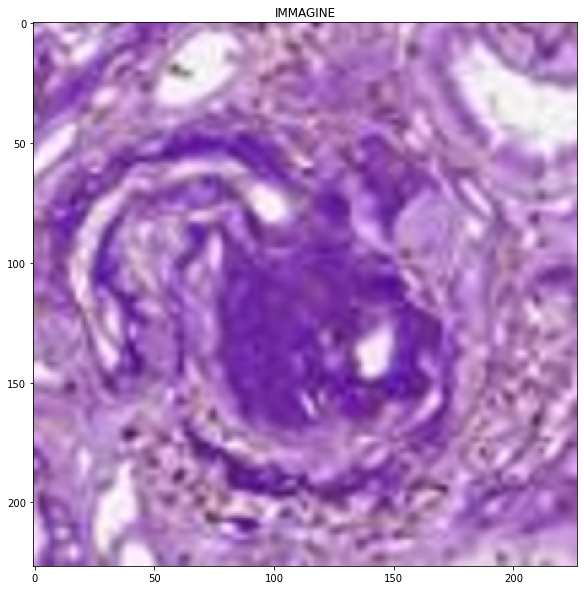

In [7]:
# Display original image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title('IMMAGINE')
plt.show()


In [8]:
# ESTRAGGO HEATMAP
heatmap = prova.cam_heatmap(img_array)

****************************************************
 STAMPA "debug"
 TIPO  lastConv_outputs  = <class 'numpy.ndarray'> 
 SHAPE  lastConv_outputs  = (1, 12, 12, 1024)
 MAX lastConv_outputs MAX = 5.731297492980957 
 MIN lastConv_outputs MIN = 0.0
****************************************************

****************************************************
Prediction : 
bird 	 = 0.000%
cat 	 = 1.000%
Prediction : [1.0795954e-04 9.9989200e-01] 
 preds shape = (1, 2)
****************************************************

****************************************************
 STAMPA "debug"
 TIPO  class_weights  = <class 'numpy.ndarray'> 
 SHAPE  class_weights  = (1024, 2)
 MAX class_weights MAX = 0.07661717385053635 
 MIN class_weights MIN = -0.07753868401050568
****************************************************
****************************************************
 STAMPA "debug"
 TIPO  cam  = <class 'numpy.ndarray'> 
 SHAPE  cam  = (12, 12)
 MAX cam MAX = 1.0 
 MIN cam MIN = -0.20934528112411

In [9]:
# trasformo la mappa di attivazione (heatmap) in immagine per sovrapporla all'originale
heatmapColored = prova.get_cam_for_img()

****************************************************
 STAMPA "debug"
 TIPO  heatmap_colormap  = <class 'numpy.ndarray'> 
 SHAPE  heatmap_colormap  = (227, 227, 3)
 MAX heatmap_colormap MAX = 255 
 MIN heatmap_colormap MIN = 0
****************************************************


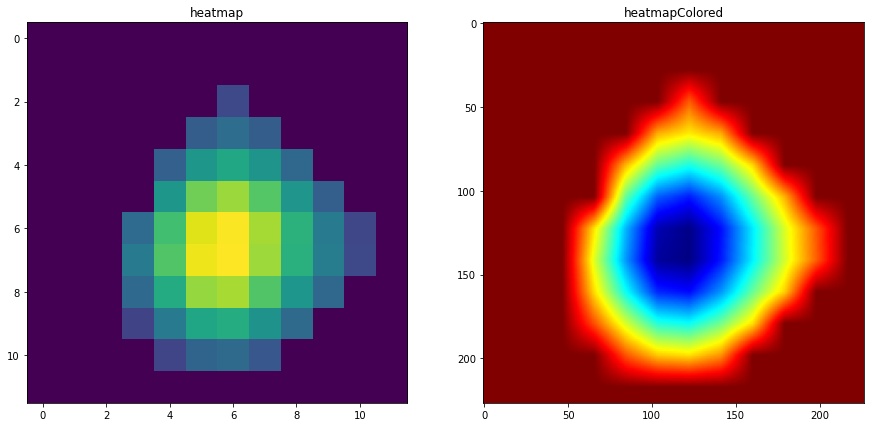

In [10]:
# visualizzo la heatmap originata dall'ultimo layer "conv" e la trasformazione in immaginr RGB
# con altezza e larghezza dell'immagine originale pronta per la sovrapposizione

titles = ['heatmap','heatmapColored']
images = [heatmap, heatmapColored]
plt.figure(figsize=(15, 10))
for i in range(2):
    #plt.subplot(1,2,i+1),plt.imshow(images[i],'gray')
    plt.subplot(1,2,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    #plt.xticks([]),plt.yticks([])
plt.show()

salvo " a portata di mano " la heatmap, l'immagine originale e quella sovrapposta


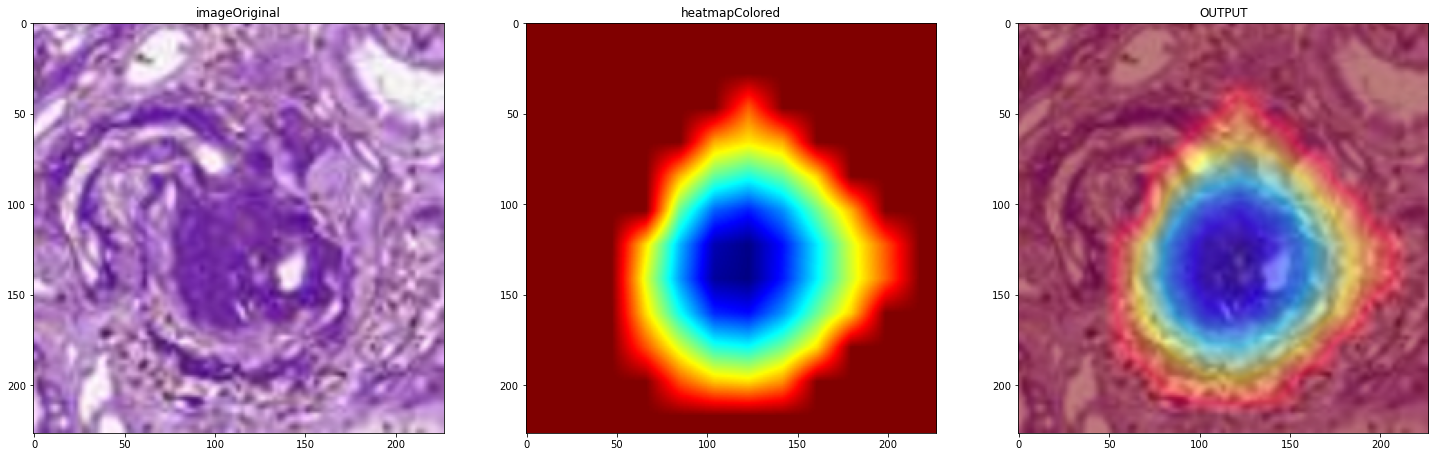

In [11]:
# SOVRAPPOSIZIONE HEATMAP CON L'IMMAGINE ORIGINALE
# posso passare come parametro il coefficiente di overlay (default = 0.5)

output = prova.overlay_heatmap()

# Display an image
titles = ['imageOriginal','heatmapColored', 'OUTPUT']
images = [image, heatmapColored, output]
plt.figure(figsize=(25, 25))
for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    #plt.xticks([]),plt.yticks([])
plt.show()

82 91 77 85


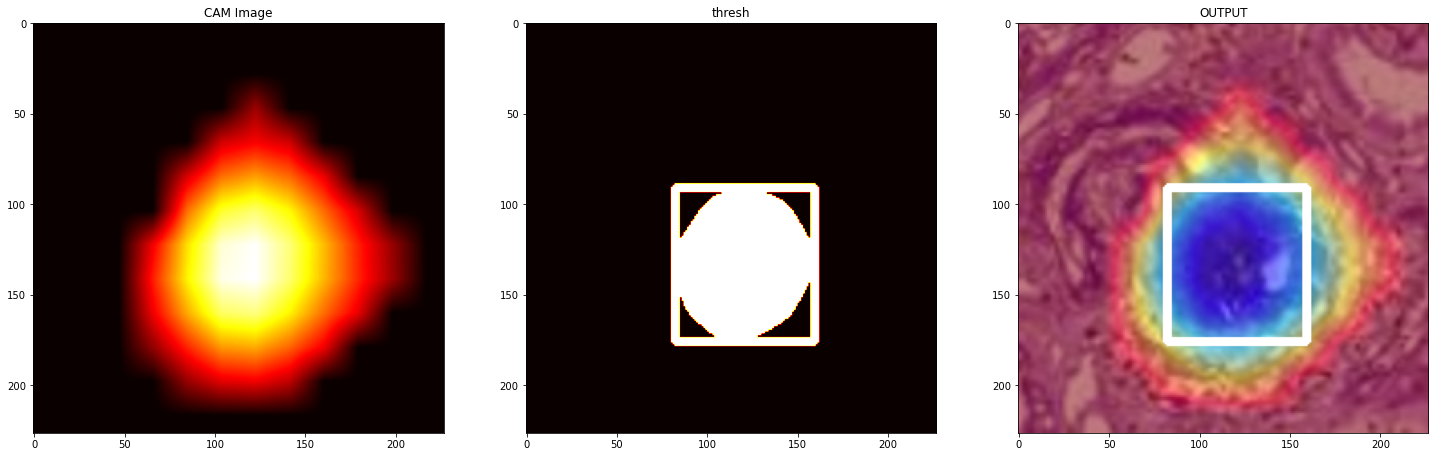

In [12]:
# uso metodo setTestBboxTxt(self, output, pathFileTxt = './Notebook/3_CAMs/Bbox_txt/testBbox.txt') 
# per memorizzare il Bbox estrapolato dalla heatmap
# il metodo restituisce una tupla con "tresh" e output (ho anche memorizzato su file i Bbox)

(thresh, outputBbox) = prova.set_testBboxTxt(output)
    
# USO PYPLOT PER VISUALIZZARE IMMAGINI
titles = ['CAM Image','thresh', 'OUTPUT']
#images = [heatmap, thresh, output]
images = [prova.heatmapResizeImg1ch, thresh, output]
plt.figure(figsize=(25, 25))
for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images[i], 'hot')
    plt.title(titles[i])
plt.show()

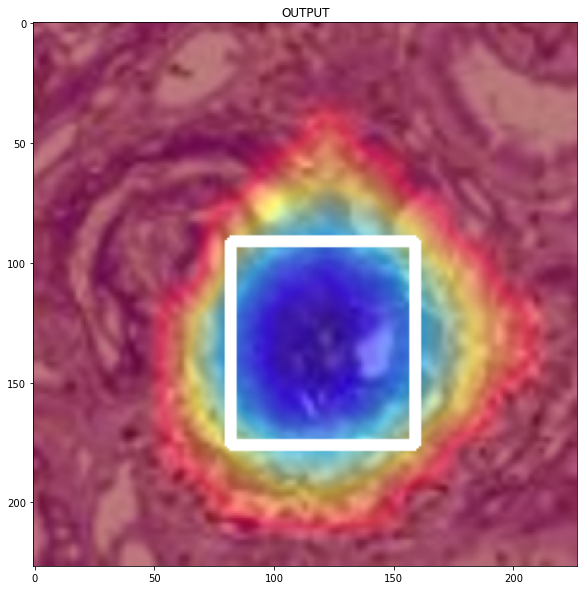

In [13]:
plt.figure(figsize=(15, 10))
plt.imshow(output)
plt.title('OUTPUT')
plt.show()

In [14]:
try:
    device.reset()
except:
    pass